## 1. 데이터 준비 및 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 데이터 로드
df = pd.read_csv('../data/raw-data/Building_X.csv')

# 타임스탬프를 datetime 객체로 변환
df['record_timestamp'] = pd.to_datetime(df['record_timestamp'], dayfirst=True)
df = df.set_index('record_timestamp')

# 결측치 처리
df = df.dropna()

In [6]:
df.head()

,CHR-01-KW,CHR-01-CHWSWT,CHR-01-CHWRWT,CHR-01-CHWFWR,CHR-02-KW,CHR-02-CHWSWT,CHR-02-CHWRWT,CHR-02-CHWFWR,CHR-03-KW,CHR-03-CHWSWT,CHR-03-CHWRWT,CHR-03-CHWFWR
record_timestamp,,,,,,,,,,,,
2023-01-01 00:00:00,0.0,12.2,11.8,0.0,8.8773,7.1,8.4,7.20833,0.00000,11.1,12.5,0.00000
2023-01-01 00:15:00,0.0,12.2,11.7,0.0,0.0000,8.8,9.0,0.00000,0.00000,11.1,12.3,0.00000
2023-01-01 00:30:00,0.0,12.2,11.7,0.0,0.0000,9.0,9.2,0.00000,20.39060,8.4,11.2,7.38056
2023-01-01 00:45:00,0.0,12.2,11.7,0.0,0.0000,9.2,9.2,0.00000,5.89547,7.4,8.2,7.06389
2023-01-01 01:00:00,0.0,12.1,11.6,0.0,0.0000,9.2,9.3,0.00000,7.84033,7.5,8.7,7.05833


## 2. 특성 선택 및 시계열 데이터 준비

In [7]:
from sklearn.preprocessing import MinMaxScaler

# 타겟 변수 선택 (모든 냉각기의 전력 소비량 합계)
df['total_power'] = df['CHR-01-KW'] + df['CHR-02-KW'] + df['CHR-03-KW']

# 입력 특성 선택
features = ['CHR-01-KW', 'CHR-01-CHWSWT', 'CHR-01-CHWRWT', 'CHR-01-CHWFWR',
            'CHR-02-KW', 'CHR-02-CHWSWT', 'CHR-02-CHWRWT', 'CHR-02-CHWFWR',
            'CHR-03-KW', 'CHR-03-CHWSWT', 'CHR-03-CHWRWT', 'CHR-03-CHWFWR']

# 시간 관련 특성 추가
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

features += ['hour', 'day_of_week', 'month']

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[['total_power']])

## 3. PyTorch 데이터셋 및 데이터로더 구현

In [9]:
class ChillerDataset(Dataset):
    def __init__(self, X, y, seq_length=24):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, idx):
        # 시퀀스 생성
        X_seq = self.X[idx:idx + self.seq_length]
        y_target = self.y[idx + self.seq_length]

        # NumPy 배열을 PyTorch 텐서로 변환
        X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
        y_target_tensor = torch.tensor(y_target, dtype=torch.float32)

        return X_seq_tensor, y_target_tensor

# 시퀀스 길이 정의 (24시간)
seq_length = 24

# 데이터셋을 시간 순서로 훈련/검증/테스트 분할 (70%, 15%, 15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Dataset 객체 생성
train_dataset = ChillerDataset(X_train, y_train, seq_length)
val_dataset = ChillerDataset(X_val, y_val, seq_length)
test_dataset = ChillerDataset(X_test, y_test, seq_length)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4. LSTM 모델 구현

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 레이어
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )

        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout_prob)

        # 최종 출력 레이어
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 은닉 및 셀 상태 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 레이어 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시간 단계의 출력만 사용
        out = out[:, -1, :]

        # 드롭아웃 적용
        out = self.dropout(out)

        # 출력 레이어 통과
        out = self.fc(out)

        return out

# 모델 초기화
input_size = len(features)  # 입력 특성 개수
hidden_size = 64  # LSTM 은닉 차원
num_layers = 2    # LSTM 층 수
output_size = 1   # 출력 차원 (전력 소비량)
dropout_prob = 0.2  # 드롭아웃 확률

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob)

# GPU 사용 가능하면 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")
print(model)

Using device: cpu
LSTMModel(
  (lstm): LSTM(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. 손실 함수 및 옵티마이저 설정

In [12]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 (선택 사항)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
)

## 6. 훈련 함수 구현

Epoch 1/50 | Train Loss: 0.0080 | Val Loss: 0.0063
Epoch 2/50 | Train Loss: 0.0081 | Val Loss: 0.0065
Epoch 3/50 | Train Loss: 0.0077 | Val Loss: 0.0064
Epoch 4/50 | Train Loss: 0.0073 | Val Loss: 0.0056
Epoch 5/50 | Train Loss: 0.0064 | Val Loss: 0.0045
Epoch 6/50 | Train Loss: 0.0050 | Val Loss: 0.0031
Epoch 7/50 | Train Loss: 0.0036 | Val Loss: 0.0029
Epoch 8/50 | Train Loss: 0.0028 | Val Loss: 0.0028
Epoch 9/50 | Train Loss: 0.0024 | Val Loss: 0.0029
Epoch 10/50 | Train Loss: 0.0022 | Val Loss: 0.0029
Epoch 11/50 | Train Loss: 0.0021 | Val Loss: 0.0030
Epoch 12/50 | Train Loss: 0.0020 | Val Loss: 0.0029
Epoch 13/50 | Train Loss: 0.0020 | Val Loss: 0.0029
Epoch 14/50 | Train Loss: 0.0019 | Val Loss: 0.0029
Epoch 15/50 | Train Loss: 0.0018 | Val Loss: 0.0023
Epoch 16/50 | Train Loss: 0.0017 | Val Loss: 0.0025
Epoch 17/50 | Train Loss: 0.0016 | Val Loss: 0.0028
Epoch 18/50 | Train Loss: 0.0016 | Val Loss: 0.0025
Epoch 19/50 | Train Loss: 0.0015 | Val Loss: 0.0026
Epoch 20/50 | Train L

/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s

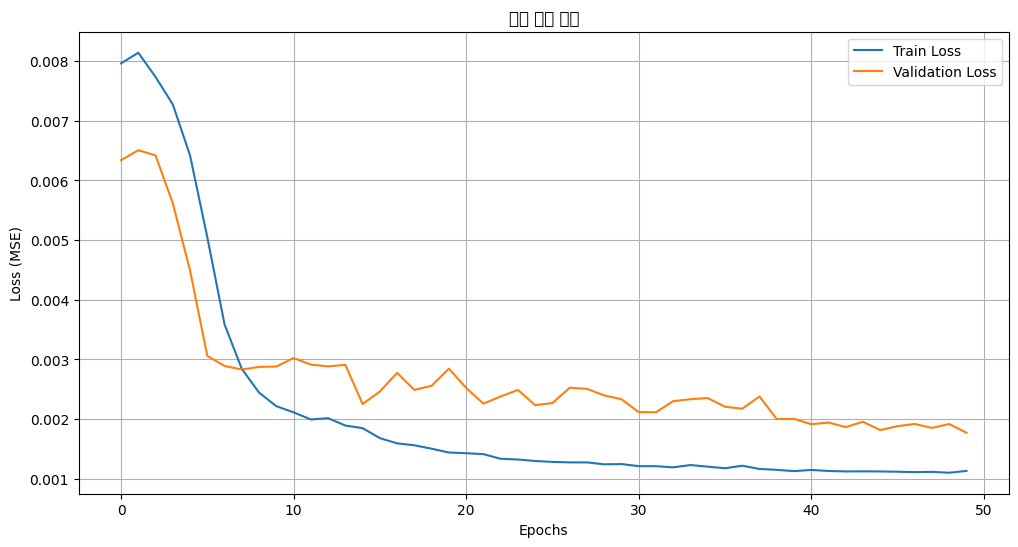

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            # 데이터를 디바이스로 이동
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(X_batch)

            # 손실 계산
            loss = criterion(outputs, y_batch)

            # 역전파 및 옵티마이저 단계
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # 평균 훈련 손실 계산
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # 검증 모드
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # 데이터를 디바이스로 이동
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # 예측
                outputs = model(X_batch)

                # 손실 계산
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        # 평균 검증 손실 계산
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # 학습률 스케줄러 업데이트
        scheduler.step(val_loss)

        # 최적 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    # 최적 모델 상태로 복원
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

# 모델 훈련
num_epochs = 50
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device
)

# 훈련 진행 상황 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('모델 훈련 과정')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 7. 모델 평가

Test Loss (MSE): 0.0083
Test RMSE: 10.3559
Test MAE: 9.5562


/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jsyoon/Library/Caches/pypoetry/virtualenvs/pure-lstm-mtv0ePvh-py3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s

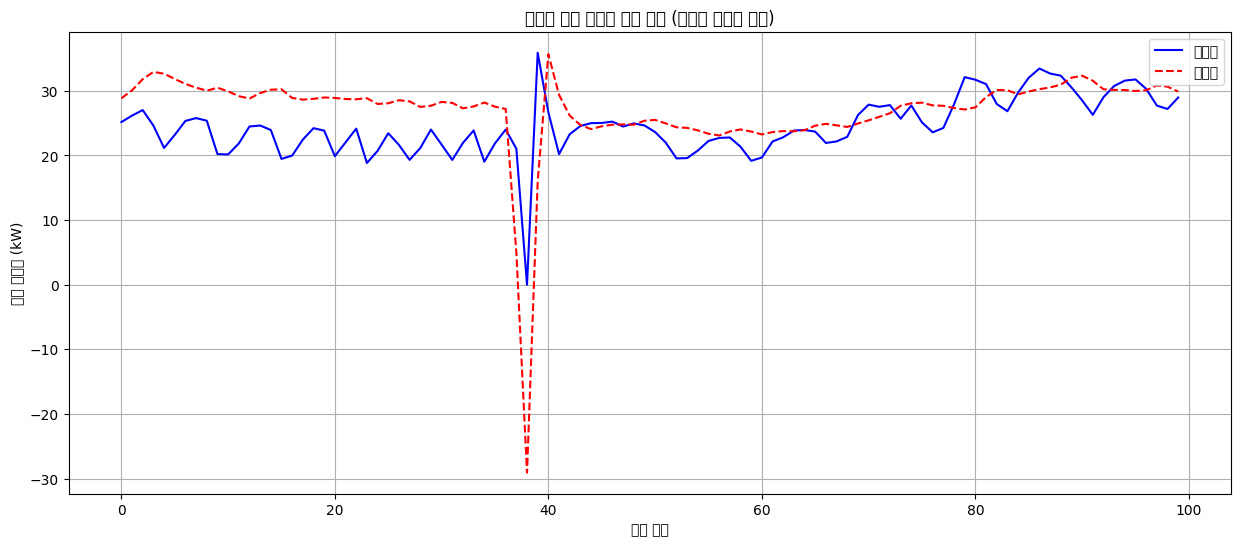

In [14]:
def evaluate_model(model, test_loader, criterion, device, scaler_y):
    model.eval()
    test_loss = 0.0

    # 예측과 실제 값을 저장할 리스트
    predictions = []
    actual_values = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # 데이터를 디바이스로 이동
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # 예측
            outputs = model(X_batch)

            # 손실 계산
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # 텐서를 CPU로 이동 후 NumPy 배열로 변환
            predictions.append(outputs.cpu().numpy())
            actual_values.append(y_batch.cpu().numpy())

    # 평균 테스트 손실 계산
    test_loss = test_loss / len(test_loader.dataset)

    # 예측값과 실제값을 하나의 배열로 병합
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)

    # 역정규화
    predictions_denorm = scaler_y.inverse_transform(predictions)
    actual_values_denorm = scaler_y.inverse_transform(actual_values)

    # RMSE 계산
    rmse = np.sqrt(np.mean((predictions_denorm - actual_values_denorm) ** 2))

    # MAE 계산
    mae = np.mean(np.abs(predictions_denorm - actual_values_denorm))

    print(f'Test Loss (MSE): {test_loss:.4f}')
    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE: {mae:.4f}')

    return predictions_denorm, actual_values_denorm

# 모델 평가
y_pred, y_true = evaluate_model(model, test_loader, criterion, device, scaler_y)

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_true[:100, 0], label='실제값', color='blue')
plt.plot(y_pred[:100, 0], label='예측값', color='red', linestyle='--')
plt.title('냉각기 전력 소비량 예측 결과 (테스트 데이터 일부)')
plt.xlabel('시간 단계')
plt.ylabel('전력 소비량 (kW)')
plt.legend()
plt.grid(True)
plt.show()

## 9. 모델 저장 및 로드

In [ ]:
# 모델 저장
def save_model(model, path, scaler_X, scaler_y):
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_size': model.lstm.input_size,
            'hidden_size': model.hidden_size,
            'num_layers': model.num_layers,
            'output_size': model.fc.out_features,
            'dropout_prob': model.dropout.p
        }
    }, path)

    # 스케일러 저장
    import joblib
    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')

# 모델 로드
def load_model(path, device):
    checkpoint = torch.load(path, map_location=device)
    config = checkpoint['model_config']

    model = LSTMModel(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        output_size=config['output_size'],
        dropout_prob=config['dropout_prob']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    # 스케일러 로드
    import joblib
    scaler_X = joblib.load('scaler_X.pkl')
    scaler_y = joblib.load('scaler_y.pkl')

    return model, scaler_X, scaler_y

# 모델 저장
save_model(model, 'chiller_lstm_model.pth', scaler_X, scaler_y)